## Урок 4.
# Способы улучшения полученной модели.

**План занятия**

* [Теоретическая часть](#theory)
    * [Переобучение и способы борьбы с ним](#overfitting)
    * [Регуляризация](#regularization)
    * [Заполнение пропусков/выбросов](#imputer)
* [Практическая часть](#practice)
    * [LogisticRegression](#lr)
    * [Support Vector Machine](#svm)
    * [XGBoost](#xgb)
    * [CatBoost](#cat)
        * [Модель, полученная на предыдущем уроке](#model_from_prev_lesson)
        * [Снижение степени переобучения](#lowering_overfitting)
        * [Подбор оптимального размера выборки, кривая обучения](#learning_curve)
        * [Выбор порога вероятности для определения класса](#threshold_calibration)
        * [Важность признаков](#feature_importances)  
        * [Финальная модель](#final_model)
        * [Сохранение финальной модели](#final_model_saving)

## <center>Теоретическая часть<a class="anchor" id="theory"></a><center>

### Переобучение и способы борьбы с ним<a class="anchor" id="overfitting"></a>

**Переобучение**

Нежелательное явление, возникающее при решении задач обучения по прецедентам, когда вероятность ошибки обученного алгоритма на объектах тестовой выборки оказывается существенно выше, чем средняя ошибка на обучающей выборке. Переобучение возникает при использовании избыточно сложных моделей.

<img src="overfitting.svg" alt="Drawing" style="width: 500px;">

**Способы борьбы с переобучением**

1. Обнаружить переобучение:
    * отложенная выборка
    * кросс-валидация
    * меры сложности модели
2. Взять больше данных
3. Взять меньше признаков
4. Выбрать более простую модель
5. Регуляризация

### Регуляризация<a class="anchor" id="regularization"></a>

Метод регуляризации заключается в "штрафовании" модели за слишком большие веса путем добавления нового члена к ошибке:

$$Q(w, X) + \lambda ||w||^{2} \rightarrow \underset{w}{\text{min}}.$$

добавленный член $\lambda ||w||^{2}$ - **квадратичный регуляризатор**, который представляет собой $L_{2}$-норму вектора весов, то есть сумму квадратов весов $\sum^{d}_{j=1}w_{j}^{2}$, коэффициент $\lambda$ при нем - коэффициент регуляризации.

Чем больше его $\lambda$, тем меньшая сложность модели будет получаться в процессе такого обучения.
    - Если увеличивать его, в какой-то момент оптимальным для модели окажется зануление всех весов
    - А при слишком низких его значениях появляется вероятность чрезмерного усложнения модели и переобучения
    - Подбираем по кросс-валидации

По сути, смысл регуляризации заключается в минимизации функционала ошибки с ограничением весов.

$$\begin{cases} Q(w, X) \rightarrow min \\ ||w||^2 \leq C \end{cases}$$

**L1-регуляризация** (lasso, регуляризация через манхэттенское расстояние)

$\large L_1 = \sum_{i=1} (y_i - \widehat{y_i})^2 + \lambda\sum_{j=1} |w_j|$

**L2-регуляризация** (ridge, регуляризация Тихонова)

$\large L_2 = \sum_{i=1} (y_i - \widehat{y_i})^2 + \lambda\sum_{j=1} w_j^2$

## <center>Практическая часть<a class="anchor" id="practice"></a><center>

**Подключение библиотек и скриптов**

In [3]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
import xgboost as xgb
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [5]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [6]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [7]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [8]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [9]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_['NEXT_MONTH_DEFAULT'] == minor_class_name]
        tmp = df_[df_['NEXT_MONTH_DEFAULT'] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)


    return df.sample(frac=1) 

**Пути к директориям и файлам**

In [10]:
DATA_ROOT = Path('./data/training_project/')
MODELS_PATH = Path('./models/')

# input
DATASET_PATH = DATA_ROOT / 'training_project_data.csv'
PREP_DATASET_PATH = DATA_ROOT / 'training_project_data_prep.csv'

# output
TRAIN_FULL_PATH = DATA_ROOT / 'training_project_train_full.csv'
TRAIN_PART_PATH = DATA_ROOT / 'training_project_train_part_b.csv'
TEST_PART_PATH = DATA_ROOT / 'training_project_test_part.csv'

SCALER_FILE_PATH = MODELS_PATH / 'scaler.pkl'
MODEL_FILE_PATH = MODELS_PATH / 'model.pkl'

### Загрузка подготовленных датасетов<a class="anchor" id="data_loading"></a>

**Загрузка данных**

In [11]:
df = pd.read_csv(TRAIN_FULL_PATH)
df_train = pd.read_csv(TRAIN_PART_PATH)
df_test = pd.read_csv(TEST_PART_PATH)

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 61 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LIMIT_BAL           7000 non-null   float64
 1   AGE                 7000 non-null   float64
 2   BILL_AMT1           7000 non-null   float64
 3   BILL_AMT2           7000 non-null   float64
 4   BILL_AMT3           7000 non-null   float64
 5   BILL_AMT4           7000 non-null   float64
 6   BILL_AMT5           7000 non-null   float64
 7   BILL_AMT6           7000 non-null   float64
 8   PAY_AMT1            7000 non-null   float64
 9   PAY_AMT2            7000 non-null   float64
 10  PAY_AMT3            7000 non-null   float64
 11  PAY_AMT4            7000 non-null   float64
 12  PAY_AMT5            7000 non-null   float64
 13  PAY_AMT6            7000 non-null   float64
 14  SEX                 7000 non-null   int64  
 15  EDUCATION           7000 non-null   int64  
 16  MARRIA

**Выделение признакового описания и целевой переменной**

In [11]:
TARGET_NAME = 'NEXT_MONTH_DEFAULT'
BASE_FEATURE_NAMES = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
                      'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                      'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

NUM_FEATURE_NAMES = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                     'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

CAT_FEATURE_NAMES = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [12]:
X = df.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
y = df[TARGET_NAME]

X_train = df_train.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
y_train = df_train[TARGET_NAME]

X_test = df_test.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
y_test = df_test[TARGET_NAME]

In [14]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')
    
df_balanced[TARGET_NAME].value_counts()

0    5464
1    4608
Name: NEXT_MONTH_DEFAULT, dtype: int64

In [15]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

### Заполнение пропусков/выбросов<a class='anchor' id='imputer'>

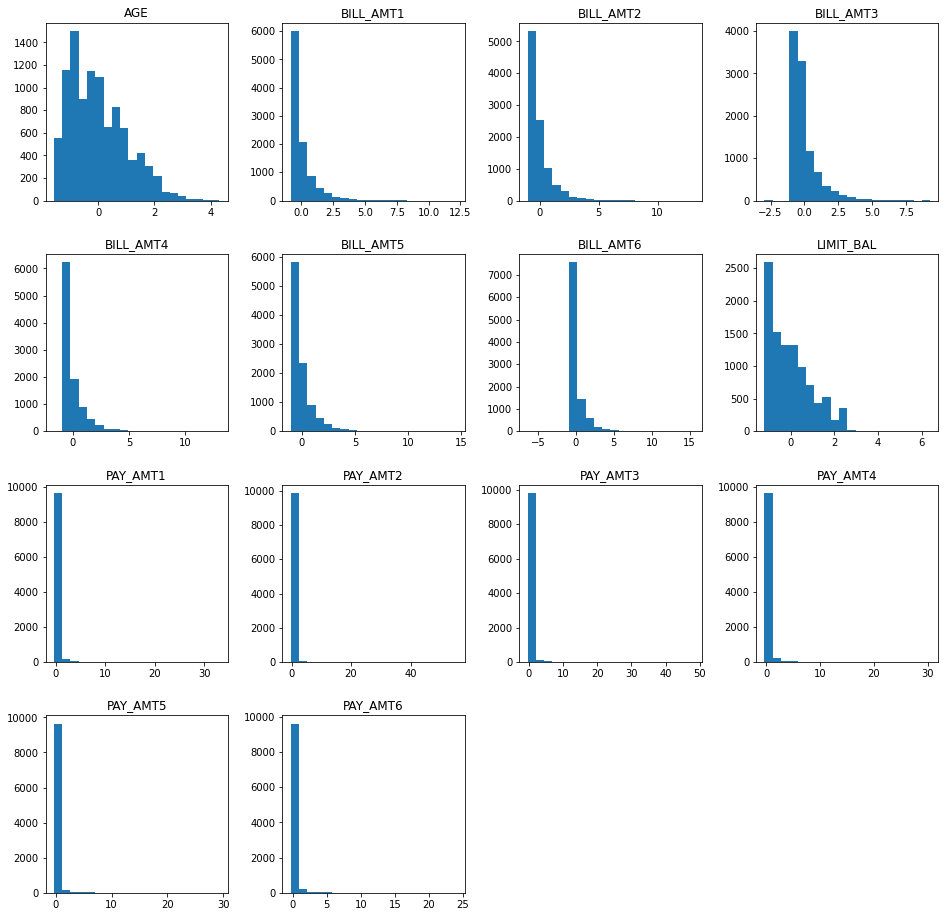

In [16]:
df[NUM_FEATURE_NAMES].hist(figsize=(16,16), bins=20, grid=False);

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler

def imputer_rfr(data, target_col):
    data = data.copy()
    
    features = data.columns
    
    data = data[features]
    
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)
    
    model = RandomForestRegressor(n_estimators=100,
                                  max_depth=10,
                                  random_state=42,
                                  verbose=1)
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f"r2 на train: {r2_score(y_train, pred_train)}")
    print(f"r2 на test: {r2_score(y_test, pred_test)}")

    pred = model.predict(predict_data.drop(columns=target_col))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    return model, data

In [40]:
df_copy = df.copy()
df_test_copy = df_test.copy()

In [41]:
df_copy.isna().sum().sum()

0

**BILL_AMT_1**

In [42]:
def preprocess_outlier(df, col, threshold):
    # можно по threshold отсекать, а можно и по квантилям
    df.loc[df[col] > threshold, col] = np.nan
    return df

feature_name = 'BILL_AMT1'
df_copy = preprocess_outlier(df_copy, feature_name, threshold=5)
df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=5)

df_copy[feature_name].isna().sum()

56

In [43]:
%%time
bill_amt1_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.9760341418393054
r2 на test: 0.9220911334360736
CPU times: user 8.89 s, sys: 0 ns, total: 8.89 s
Wall time: 8.91 s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [44]:
df_copy[feature_name].isna().sum()

0

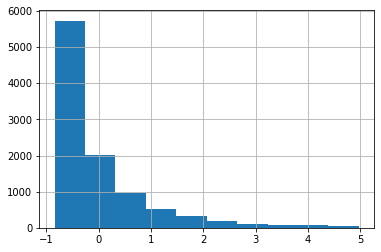

In [45]:
df_copy[feature_name].hist();

**PAY_AMT1**

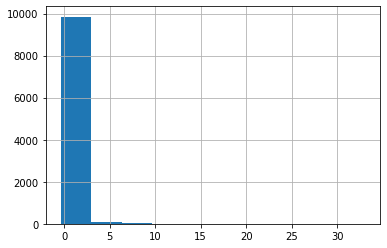

In [46]:
feature_name = 'PAY_AMT1'
df_copy[feature_name].hist();

In [47]:
df_copy = preprocess_outlier(df_copy, feature_name, threshold=5)
df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=5)

df_copy[feature_name].isna().sum()

68

In [48]:
pay_amt1_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.9172825911459225
r2 на test: 0.7442223568889579


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [49]:
df_copy[feature_name].isna().sum()

0

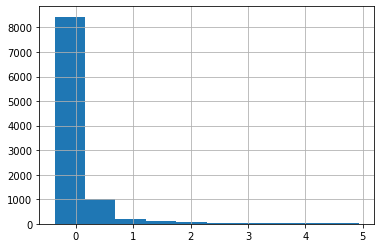

In [50]:
df_copy[feature_name].hist();

## Logistic Regression <a class='anchor' id='lr'>

In [77]:
model_lr = LogisticRegression(C=1,
                              max_iter=100
                              )
model_lr.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_lr, X_train_balanced, X_test, y_train_balanced, y_test)
model_lr.intercept_, model_lr.coef_

TRAIN

              precision    recall  f1-score   support

           0       0.69      0.86      0.77      5464
           1       0.77      0.54      0.63      4608

    accuracy                           0.71     10072
   macro avg       0.73      0.70      0.70     10072
weighted avg       0.72      0.71      0.70     10072

TEST

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      2341
           1       0.54      0.51      0.52       659

    accuracy                           0.80      3000
   macro avg       0.70      0.69      0.70      3000
weighted avg       0.79      0.80      0.79      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   2053  288
1                    325  334


(array([-0.18418351]),
 array([[-0.18368671,  0.03576017, -0.32462279,  0.52006911,  0.10287384,
         -0.04791282,  0.11474061, -0.22354942, -0.26538219, -0.03338583,
         -0.03569686,  0.01642039, -0.11714712, -0.14872114,  0.19867209,
          0.75217904,  0.8044493 ,  0.80523317, -0.0652693 , -1.72253952,
         -0.7235353 , -0.10505343, -0.26653428,  0.22210509, -0.64384387,
         -1.10993211, -0.15304954,  1.03104164,  0.72630126,  0.04497693,
          0.31744552, -1.26094021,  0.3297609 ,  0.41927424,  0.01497542,
         -0.09383975, -0.34427551,  0.43727682, -0.1636196 , -0.23472349,
         -0.24601375,  0.10297699,  0.22827762, -0.10175596, -0.0509796 ,
          0.33307275, -0.32981982, -0.07458361, -0.41389897, -0.02289596,
          0.36189593]]))

In [64]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [80]:
model_lr_cv = LogisticRegressionCV(max_iter=100,
                                   cv=cv, Cs=10
                                   )
model_lr_cv.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_lr_cv, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.69      0.87      0.77      5464
           1       0.77      0.53      0.63      4608

    accuracy                           0.72     10072
   macro avg       0.73      0.70      0.70     10072
weighted avg       0.73      0.72      0.71     10072

TEST

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      2341
           1       0.55      0.51      0.53       659

    accuracy                           0.80      3000
   macro avg       0.71      0.70      0.70      3000
weighted avg       0.80      0.80      0.80      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   2072  269
1                    324  335


In [81]:
model_lr_cv.Cs_

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])

In [82]:
model_lr_cv.C_

array([0.00599484])

## Support Vector Machine <a class='anchor' id='svm'>

In [90]:
model_svc = SVC(C=1,
                kernel='rbf',
#                 degree=3
                )
model_svc.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_svc, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.87      0.79      5464
           1       0.79      0.59      0.68      4608

    accuracy                           0.74     10072
   macro avg       0.75      0.73      0.73     10072
weighted avg       0.75      0.74      0.74     10072

TEST

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      2341
           1       0.54      0.50      0.52       659

    accuracy                           0.80      3000
   macro avg       0.70      0.69      0.69      3000
weighted avg       0.79      0.80      0.79      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   2056  285
1                    330  329


## XGBoost<a class='anchor' id='xgb'>

In [91]:
model_xgb = xgb.XGBClassifier(random_state=21, 
                              max_depth=3, 
                              )
model_xgb.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.85      0.79      5464
           1       0.78      0.63      0.69      4608

    accuracy                           0.75     10072
   macro avg       0.76      0.74      0.74     10072
weighted avg       0.75      0.75      0.74     10072

TEST

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      2341
           1       0.52      0.57      0.54       659

    accuracy                           0.79      3000
   macro avg       0.70      0.71      0.70      3000
weighted avg       0.80      0.79      0.79      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1997  344
1                    286  373


In [92]:
params = {
    'reg_lambda': [0.2, 0.5, 0.9, 1.3, 1.9, 3, 5, 10]
}

In [93]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [94]:
%%time
grid_search = GridSearchCV(param_grid=params, estimator=model_xgb, cv=cv, verbose=2, scoring='f1')
grid_search.fit(X_train_balanced, y_train_balanced)
display(grid_search.best_params_, grid_search.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] reg_lambda=0.2 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................... reg_lambda=0.2, total=   1.5s
[CV] reg_lambda=0.2 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] ................................... reg_lambda=0.2, total=   1.3s
[CV] reg_lambda=0.2 ..................................................
[CV] ................................... reg_lambda=0.2, total=   1.3s
[CV] reg_lambda=0.5 ..................................................
[CV] ................................... reg_lambda=0.5, total=   1.4s
[CV] reg_lambda=0.5 ..................................................
[CV] ................................... reg_lambda=0.5, total=   1.3s
[CV] reg_lambda=0.5 ..................................................
[CV] ................................... reg_lambda=0.5, total=   1.3s
[CV] reg_lambda=0.9 ..................................................
[CV] ................................... reg_lambda=0.9, total=   1.4s
[CV] reg_lambda=0.9 ..................................................
[CV] ................................... reg_lambda=0.9, total=   1.3s
[CV] reg_lambda=0.9 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   33.4s finished


{'reg_lambda': 0.5}

0.6785818049303143

CPU times: user 35.4 s, sys: 42.8 ms, total: 35.4 s
Wall time: 35.5 s


In [95]:
model_xgb = xgb.XGBClassifier(random_state=21, 
                              max_depth=1, 
                              reg_lambda=0.5
                             )
model_xgb.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.88      0.77      5464
           1       0.78      0.52      0.63      4608

    accuracy                           0.71     10072
   macro avg       0.73      0.70      0.70     10072
weighted avg       0.73      0.71      0.70     10072

TEST

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      2341
           1       0.57      0.51      0.54       659

    accuracy                           0.81      3000
   macro avg       0.72      0.70      0.71      3000
weighted avg       0.80      0.81      0.80      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   2085  256
1                    320  339


### Подбор оптимального размера выборки, кривая обучения<a class="anchor" id="learning_curve"></a>

In [96]:
import inspect
print(inspect.getsource(show_learning_curve_plot))

def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_st

In [98]:
np.linspace(.1, 1.0, 5)

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

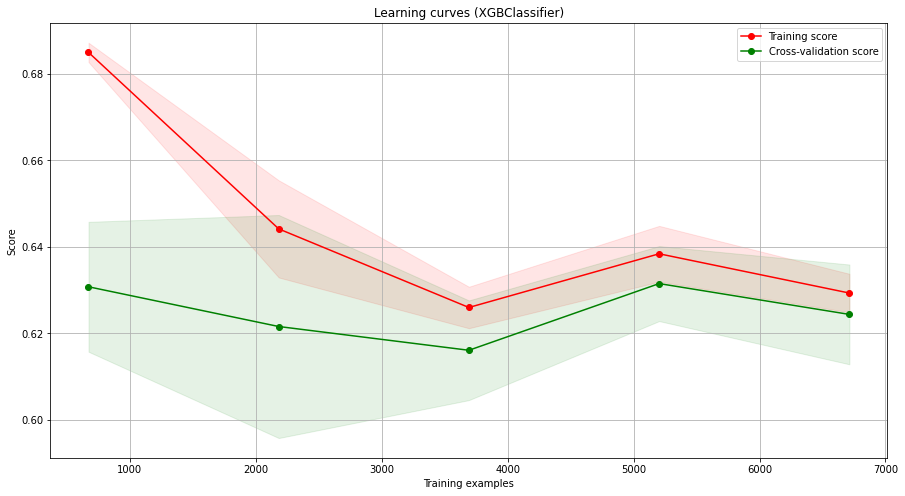

In [97]:
show_learning_curve_plot(model_xgb, X_train_balanced, y_train_balanced)

### Выбор порога вероятности для определения класса<a class="anchor" id="threshold_calibration"></a>

In [100]:
y_test_pred_probs = model_xgb.predict_proba(X_test)
y_test_pred_probs

array([[0.57665086, 0.42334917],
       [0.69469905, 0.30530098],
       [0.543643  , 0.45635697],
       ...,
       [0.65283144, 0.34716856],
       [0.31468004, 0.68531996],
       [0.70140904, 0.29859096]], dtype=float32)

In [101]:
print(inspect.getsource(show_proba_calibration_plots))

def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, labe

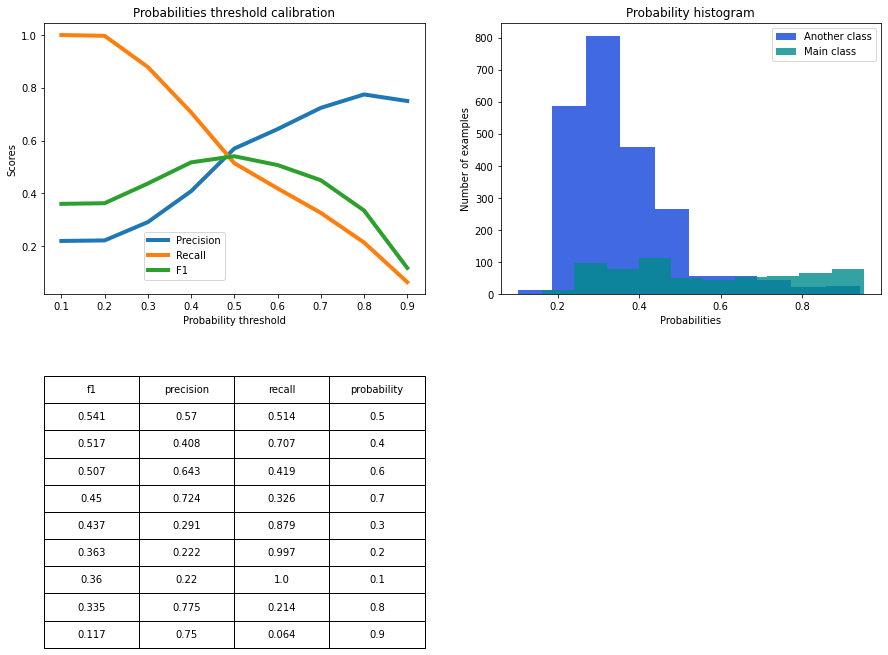

In [99]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Важность признаков<a class="anchor" id="feature_importances"></a>

In [103]:
print(inspect.getsource(show_feature_importances))

def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()



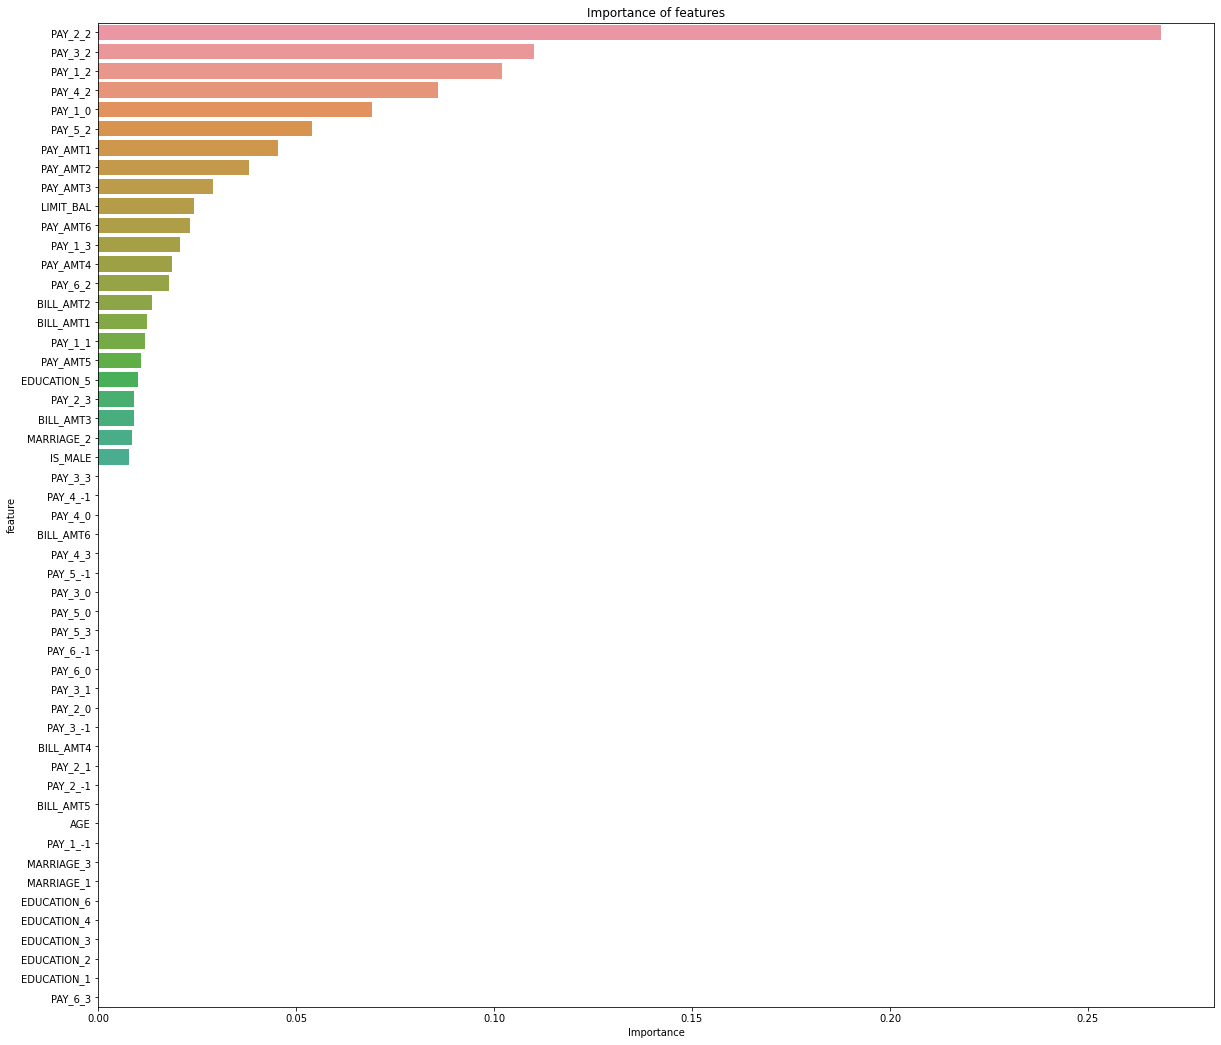

In [108]:
important_features_top = show_feature_importances(X_train_balanced.columns,
                                                  model_xgb.feature_importances_, get_top=15)

In [109]:
important_features_top

['PAY_2_2',
 'PAY_3_2',
 'PAY_1_2',
 'PAY_4_2',
 'PAY_1_0',
 'PAY_5_2',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'LIMIT_BAL',
 'PAY_AMT6',
 'PAY_1_3',
 'PAY_AMT4',
 'PAY_6_2',
 'BILL_AMT2',
 'BILL_AMT1',
 'PAY_1_1',
 'PAY_AMT5',
 'EDUCATION_5',
 'PAY_2_3',
 'BILL_AMT3',
 'MARRIAGE_2',
 'IS_MALE']

### Финальная модель<a class="anchor" id="final_model"></a>

In [110]:
final_xgb = xgb.XGBClassifier(random_state=21, 
                              max_depth=1, 
                              reg_lambda=0.5
                              )
final_xgb.fit(X_train_balanced[important_features_top], y_train_balanced)

evaluate_preds(final_xgb,
               X_train_balanced[important_features_top],
               X_test[important_features_top],
               y_train_balanced,
               y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.88      0.77      5464
           1       0.78      0.52      0.63      4608

    accuracy                           0.71     10072
   macro avg       0.73      0.70      0.70     10072
weighted avg       0.73      0.71      0.70     10072

TEST

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      2341
           1       0.57      0.51      0.54       659

    accuracy                           0.81      3000
   macro avg       0.72      0.70      0.71      3000
weighted avg       0.80      0.81      0.80      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   2085  256
1                    320  339


### Сохранение финальной модели<a class="anchor" id="final_model_saving"></a>

In [111]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_xgb, file)

## Catboost<a class='anchor' id='cat'>

In [112]:
X = df[BASE_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train = df_train[BASE_FEATURE_NAMES]
y_train = df_train[TARGET_NAME]

X_test = df_test[BASE_FEATURE_NAMES]
y_test = df_test[TARGET_NAME]

### Модель, полученная на предыдущем уроке<a class="anchor" id="model_from_prev_lesson"></a>

In [113]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

3.5572916666666665

In [114]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}

In [115]:
%%time

model_catb = catb.CatBoostClassifier(**frozen_params, iterations=300, max_depth=3)
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.80      0.85      5464
           1       0.49      0.66      0.56      1536

    accuracy                           0.77      7000
   macro avg       0.69      0.73      0.70      7000
weighted avg       0.80      0.77      0.78      7000

TEST

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      2341
           1       0.48      0.61      0.54       659

    accuracy                           0.77      3000
   macro avg       0.68      0.71      0.69      3000
weighted avg       0.79      0.77      0.78      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1914  427
1                    257  402
CPU times: user 4.56 s, sys: 417 ms, total: 4.98 s
Wall time: 2.53 s


### Снижение степени переобучения<a class="anchor" id="lowering_overfitting"></a>

In [117]:
model = catb.CatBoostClassifier(**frozen_params,
                                iterations=300,
                                max_depth=3, 
#                                 l2_leaf_reg=.5,
                                reg_lambda=0.5
                                )

model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(model, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      5464
           1       0.49      0.59      0.53      1536

    accuracy                           0.77      7000
   macro avg       0.68      0.71      0.69      7000
weighted avg       0.79      0.77      0.78      7000

TEST

              precision    recall  f1-score   support

           0       0.87      0.84      0.86      2341
           1       0.51      0.57      0.54       659

    accuracy                           0.78      3000
   macro avg       0.69      0.71      0.70      3000
weighted avg       0.79      0.78      0.79      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1977  364
1                    284  375


In [118]:
params = {
    'reg_lambda': np.linspace(0.1, 4, 80)
}

In [119]:
model = catb.CatBoostClassifier(**frozen_params,
                                iterations=300,
                                max_depth=3)

In [120]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [121]:
grid_search = model.randomized_search(params, X_train, y_train, n_iter=50, cv=cv, stratified=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.663482269
bestIteration = 105

0:	loss: 0.6634823	best: 0.6634823 (0)	total: 1.06s	remaining: 52s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6661807103
bestIteration = 89

1:	loss: 0.6661807	best: 0.6661807 (1)	total: 1.78s	remaining: 42.8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6691552858
bestIteration = 89

2:	loss: 0.6691553	best: 0.6691553 (2)	total: 2.73s	remaining: 42.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6661807103
bestIteration = 104

3:	loss: 0.6661807	best: 0.6691553 (2)	total: 3.75s	remaining: 43.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6624308124
bestIteration = 45

4:	loss: 0.6624308	best: 0.6691553 (2)	total: 4.18s	remaining: 37.6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6651867945
bestIteration = 96

5:	loss: 0.6651868	best: 0.6691553 (2)	total: 5.28s	remaining:

In [122]:
grid_search

{'params': {'l2_leaf_reg': 0.19873417721518988},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
  

In [123]:
%%time

evaluate_preds(model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.81      0.85      5464
           1       0.48      0.62      0.54      1536

    accuracy                           0.77      7000
   macro avg       0.68      0.72      0.69      7000
weighted avg       0.80      0.77      0.78      7000

TEST

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      2341
           1       0.49      0.61      0.54       659

    accuracy                           0.78      3000
   macro avg       0.69      0.72      0.70      3000
weighted avg       0.80      0.78      0.78      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1933  408
1                    260  399
CPU times: user 149 ms, sys: 138 µs, total: 149 ms
Wall time: 142 ms


### Подбор оптимального размера выборки, кривая обучения<a class="anchor" id="learning_curve"></a>

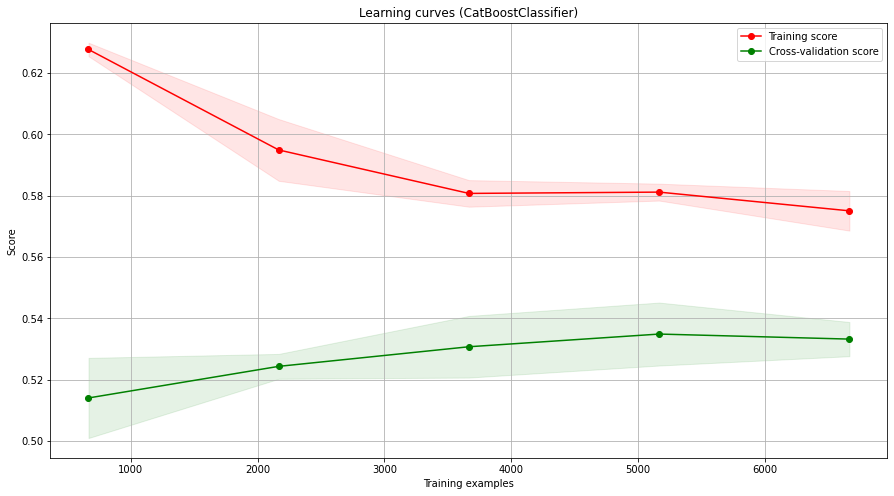

In [124]:
show_learning_curve_plot(model_catb, X, y)

### Выбор порога вероятности для определения класса<a class="anchor" id="threshold_calibration"></a>

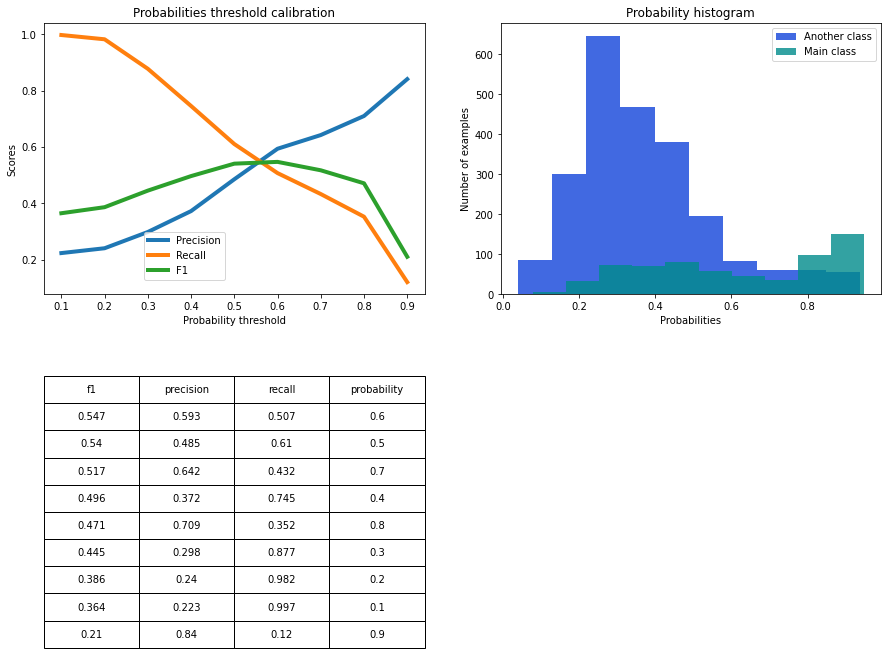

In [125]:
y_test_pred_probs = model_catb.predict_proba(X_test)
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Важность признаков<a class="anchor" id="feature_importances"></a>

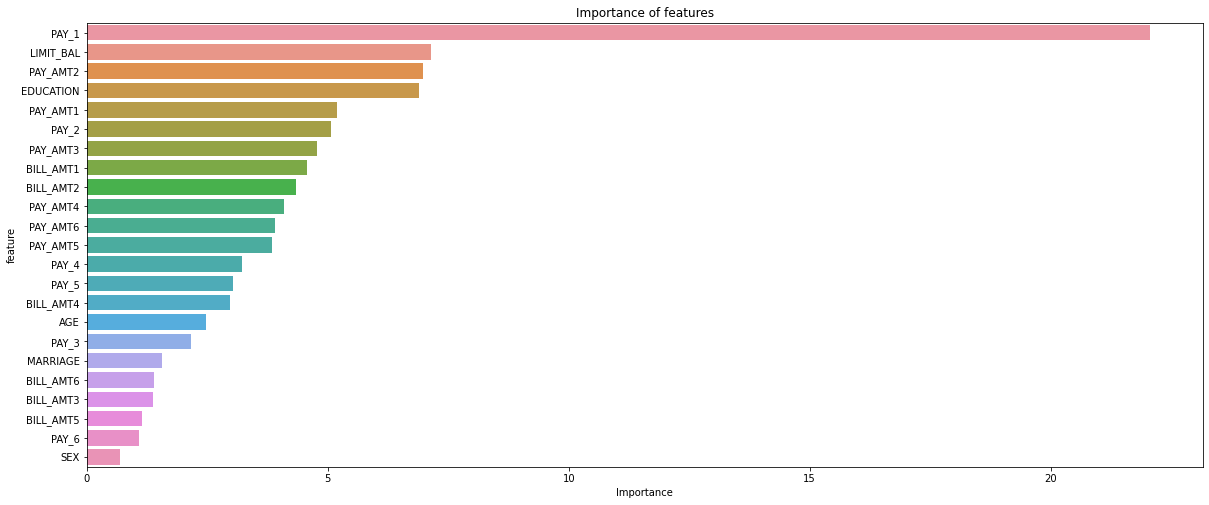

In [139]:
important_features_top = show_feature_importances(X_train.columns, model_catb.feature_importances_, get_top=15)

In [136]:
important_features_top

['PAY_1',
 'LIMIT_BAL',
 'PAY_AMT2',
 'EDUCATION',
 'PAY_AMT1',
 'PAY_2',
 'PAY_AMT3',
 'BILL_AMT1',
 'BILL_AMT2',
 'PAY_AMT4',
 'PAY_AMT6',
 'PAY_AMT5',
 'PAY_4',
 'PAY_5',
 'BILL_AMT4',
 'AGE',
 'PAY_3',
 'MARRIAGE',
 'BILL_AMT6',
 'BILL_AMT3',
 'BILL_AMT5',
 'PAY_6',
 'SEX']

### Финальная модель<a class="anchor" id="final_model"></a>

In [137]:
NEW_CAT_FEATURE_NAMES = list(set(CAT_FEATURE_NAMES).intersection(set(important_features_top)))

In [138]:
%%time

frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features':NEW_CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}

final_model = catb.CatBoostClassifier(**frozen_params,
                                      iterations=300,
                                      max_depth=3,
                                      reg_lambda=0.198)

final_model.fit(X_train[important_features_top], y_train)

evaluate_preds(final_model, X_train[important_features_top], X_test[important_features_top], y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.81      0.84      5464
           1       0.48      0.63      0.54      1536

    accuracy                           0.77      7000
   macro avg       0.68      0.72      0.69      7000
weighted avg       0.80      0.77      0.78      7000

TEST

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      2341
           1       0.48      0.60      0.54       659

    accuracy                           0.77      3000
   macro avg       0.68      0.71      0.69      3000
weighted avg       0.79      0.77      0.78      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1918  423
1                    263  396
CPU times: user 5.8 s, sys: 407 ms, total: 6.2 s
Wall time: 2.29 s


### Сохранение финальной модели<a class="anchor" id="final_model_saving"></a>

In [ ]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

### Курсовой проект
https://www.kaggle.com/c/credit-default/
* F1-score > 0.5 на private Leaderboard
* F1-score_1, recall_1, precision_1 > 0.5
* Решение прикреплять в ДЗ к Урок 4. Оценка и интерпретация полученной модели. Обсуждение курсового проекта.
* Указать свой ник на kaggle
_____________

### Обобщение работы с новой задачей
1. Получить базовое решение
    * Минимально познакомиться с данными
    * Заполнить пропуски простым методом (нулями, медиана, среднее, мода...)
    * Обучить простую модель (линейная, деревья...)
    * Посчитать метрику качества


2. EDA
    * Изучить целевую переменную 
        * регрессия - распределение, меры центральной тенденции
        * классификация - баланс классов
    * Изучить признаки
        * корреляция
        * найти проблемные признаки
        * найти пропуски
        * найти выбросы
        * сгенерировать идеи по их заполнению
    * Изучить влияние признаков на целевую переменную
        * корреляция
        * классификация - разделение значений в зависимости от классов
    * Постоянно придумывать идеи для новых признаков (где-то их фиксировать)


3. Предобработка данных
    * Разделить данные на train и test
    * Зависит от выбранной модели
        * Масштабирование
    * Для классификации - балансировка дисбалансированных классов
    * Заполнить пропуски
        1. Выкинуть эти данные
        2. Заменять разными методами (медианы, средние значения, бизнес-логика, строить модели...)
        3. Делать/не делать дополнительную фичу
        4. Ничего не делать
    * Обработать выбросы
        1. Выкинуть эти данные
        2. Заменять разными методами (медианы, средние значения, бизнес-логика, строить модели...)
        3. Делать/не делать дополнительную фичу
        4. Ничего не делать
    * Генерация новых признаков
        1. Категориальные признаки
            1. pd.get_dummies, OneHotEncoder
            2. Feature Encoding
            3. Target Encoding
        2. Вещественные признаки
            1. Feature discretization
            2. Feature binarization
    * Оформить предобработку в класс/функции для воспроизводимости


4. Обучение и валидация моделей
    * Обучить модель на базовых гиперпараметрах
    * Вручную настраивать гиперпарметры
    * Автоматизированный выбор гиперпараметров с кросс-валидацией GridSearchCV/RandomSearchCV
    * Следить за переобучением, если оно появляется, то искать лучший параматер регуляризации
    * Посчитать метрики


5. Воспроизводимость
    * Зафиксировать результаты эксперимента
    * Сохранить модели
    * Сохранить версии библиотек


6. Вы и ваша модель идеальна! :)